# Exploring Chronic Absenteeism in New York's Public School System
##### by Nathaniel Green

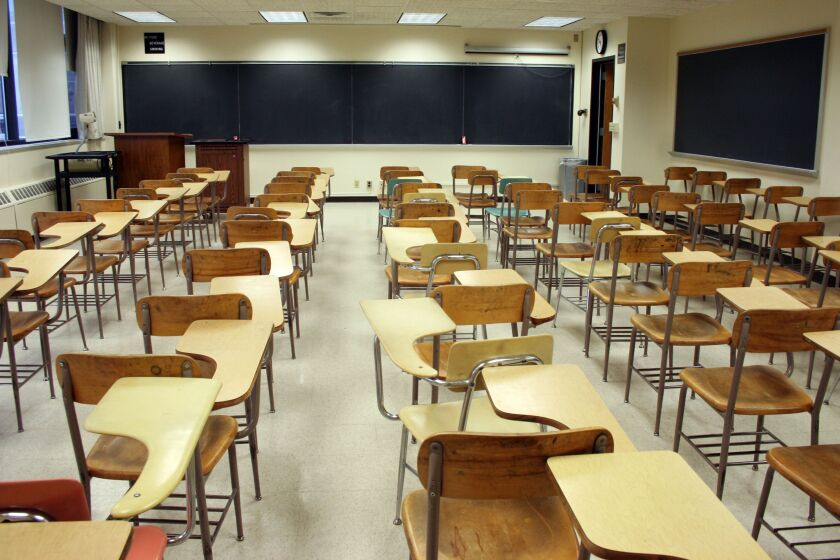

# Business Problem and Objective

Since the onset of the 2020 COVID-19 pandemic, chronic absenteeism has jumped from around 25% in 2020 to 41% in 2022, making absenteeism one of most significant problems public schools are currently facing. Chronic absenteeism is defined as a student missing 10% or more of the school days in a year. Studies have shown that students who are chronically absent have reduced reading proficiency in Elementary School and are less likely to graduate High School. With this in mind, I wanted to create a model that would be able to categorize and identify schools that are likely to have high rates of chronic absenteeism. My hope is for the Department of Education to identify the key features from the categorization model and use these features to create interventions that help address the root causes of chronic absenteeism in schools.

Three questions that I hope my model can address are as follows:

1. With what level of accuracy can schools be categorized as having or not having a high rate of chronic absenteeism?
2. What features/measures contribute the most to accurately categorizing a school as having a high rate of chronic absenteeism?
3. What other features should schools measure in order to improve the current model?

I started this modeling process by importantubg python libraries for data processing, EDA, and categorization modeling.

In [244]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



# For our modeling steps
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer


# from sklearn.preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# For demonstrative purposes
from scipy.special import logit, expit

#Get rid of warning
import warnings
warnings.filterwarnings('ignore')

#pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn import set_config

#random forest
from sklearn.ensemble import RandomForestClassifier

#model evaluation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


# Importing Data and Data Processing

After importing the python libraries, I started importing data sets that wil become part of my final dataframe. For each data set I decided to only use data from the 2020-2021 and 2021-2022 school years because I wanted to use data that was collected after the onset of the 2020 COVID-19 pandemic. I only wanted to use post COVID data because that is when Chronic Absenteeism really began to increase in New York City. The first data set that I imported was demographic data from the DOE which included features on class size, race/ethnicity, poverty rates, and rates of students with disabilities.

In [273]:
#Loading Demographic Data
df = pd.read_csv("gen_data/DOE_Demographic.csv")

# I looked at how data was split between years and noticed that the split was pretty even which is do be expected. 
df["Year"].value_counts()


2021-22    1881
2020-21    1876
2019-20    1859
2018-19    1830
2017-18    1805
Name: Year, dtype: int64

The second data set I decided to import was the DOE dataset on school attendance. For this data sets, I only included rows that had data for "all grades" because grade level data for each school was already included in the df_demo. I also dropped unneccessary columns and dropped 's' values in the '% Chronically Absent' column. The 's' value is a place holder for schools that were too small to have their data displayed. 

In [274]:
#Loading attendance data
XLS = pd.ExcelFile("gen_data/attendance_data.xlsx")
df_att = pd.read_excel(XLS, "All Students")

#only using data from all grades
df_att_all_grades = df_att[df_att["Grade"] == "All Grades"]

#dropping extra features that will not be useful in my model (All rows have the same Grade and Category)
df_att_all_grades = df_att_all_grades.drop(columns = ["Grade", "Category", "# Contributing 10+ Total Days and 1+ Pres Day"], axis = 1)

#Dropping S values from "% Chronically Absent" feature
df_att_no_s = df_att_all_grades.drop(df_att_all_grades[df_att_all_grades["% Chronically Absent"] == "s"].index)
df_att_no_s.reset_index(drop = True, inplace = True)


# Combining Data

Now that I have my two main datasets I decided to combine the datasets together and begin to perfrom some Data EDA

In [275]:
#Merging Data
df_merge_1 = pd.merge(df, df_att_no_s, on = ['DBN', 'School Name', 'Year'])


Now that I have my data merged together, lets look at the number of schools in my dataset

In [276]:
print(df_merge_1["DBN"].value_counts())
print(df_merge_1["School Name"].value_counts())

01M015    5
23K155    5
23K363    5
23K327    5
23K323    5
         ..
19K938    2
19K953    2
12X626    2
20K939    2
19K935    1
Name: DBN, Length: 1527, dtype: int64
P.S. 360                                              10
P.S. 253                                              10
P.S. 376                                              10
P.S. 150 Christopher                                   5
P.S. 327 Dr. Rose B. English                           5
                                                      ..
District 12 Pre-K Center                               2
MS 936 Arts Off 3rd                                    2
School of Earth Exploration and Discovery Harlem (     2
The East New York Arts and Civics High School          2
M.S. 935                                               1
Name: School Name, Length: 1524, dtype: int64


Looking at the value counts for school name and DBN number, it looks like we do not have the same number of school names as DBN Number. The data frame has three more DBN number than school names. Let's explore this a little bit more to ensure that there isn't an error in the data.

In [277]:
df_merge_1[df_merge_1["School Name"] == 'P.S. 376']

DBN School Name     Year  Total Enrollment  Grade 3K  \
5773  26Q376    P.S. 376  2017-18               101         0   
5774  26Q376    P.S. 376  2018-19               173         0   
5775  26Q376    P.S. 376  2019-20               243         0   
5776  26Q376    P.S. 376  2020-21               299         0   
5777  26Q376    P.S. 376  2021-22               373        15   
7267  32K376    P.S. 376  2017-18               520         0   
7268  32K376    P.S. 376  2018-19               528         0   
7269  32K376    P.S. 376  2019-20               522         0   
7270  32K376    P.S. 376  2020-21               469         0   
7271  32K376    P.S. 376  2021-22               473         0   

      Grade PK (Half Day & Full Day)  Grade K  Grade 1  Grade 2  Grade 3  ...  \
5773                              42       59        0        0        0  ...   
5774                              54       65       54        0        0  ...   
5775                              52       71       59       61        0  ...   
5776                              54       63       70       56       56  ...   
5777                              53       68       56       69       56  ...   
7267                               0       68       75       91       94  ...   
7268                               0       89       76       76      102  ...   
7269                               0       79       92       82       75  ...   
7270                               0       53       79       90       78  ...   
7271                               0       89       59       82       89  ...   

      % English Language Learners  # Poverty  % Poverty  Economic Need Index  \
5773                        0.119         54      53.5%                43.0%   
5774                        0.139         81      46.8%                40.2%   
5775                        0.140        110      45.3%                42.6%   
5776                        0.161        159      53.2%                40.4%   
5777                        0.174        191      51.2%                40.4%   
7267                        0.146        455      87.5%                84.5%   
7268                        0.152        437      82.8%                79.3%   
7269                        0.190        420      80.5%                78.9%   
7270                        0.188        376      80.2%                76.3%   
7271                        0.262        365      77.2%                77.4%   

      # Total Days  # Days Absent  # Days Present  % Attendance  \
5773         19004           1314           17690     93.085663   
5774         30198           1861           28337     93.837341   
5775         27918           1493           26425     94.652199   
5776         52210           1348           50862     97.418121   
5777         66524           4725           61799     92.897301   
7267         91907           5618           86289     93.887299   
7268         93811           5465           88346     94.174454   
7269         60067           3206           56861     94.662628   
7270         81875           4843           77032     94.084885   
7271         83460           6598           76862     92.094414   

      # Chronically Absent  % Chronically Absent  
5773                    28             24.137932  
5774                    27             15.083798  
5775                    43             16.862745  
5776                    18              5.882353  
5777                   101                    25  
7267                    96             18.011257  
7268                    87             15.846994  
7269                    79             14.766356  
7270                    95             19.269777  
7271                   127              26.23967  

[10 rows x 50 columns]

It looks like there are three sets of two school in New York City that share the same name, but have unique DBN Numbers. Looking these school up on google, but can cofirm that each one of these six school is a unique school. For this reason, I will not drop any of these schools from my data frame. This means that my in my initial dataframe, I am starting with 1527 unique schools. 

Next, I want to look at the distribution of my target feature ('% Chronically Absent'). Looking at the histogram below, we can see that their is a large range of values for rate of chronic absenteeism in New York City Schools. This shows me that chronic absenteeism does not impact every school equally in New York City.

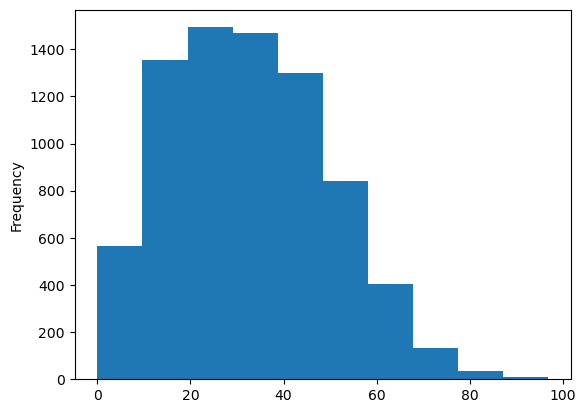

In [251]:
#Histogram of  chronic absenteeism data
attendance = df_merge_1['% Chronically Absent']
attendance.plot(kind = "hist");

The histogram above is a good start for visualizing my data, but I want to create a few more graphs in order to better understand my data. This will be a good time to get more information on our data frame. Looking at the information table of my data frame, it looks like we do not have any Null values. Good News!

I am also noticing that columns like # poverty and % poverty have a good chance of being multi-colinear. I need to explore this more through a heatmap.

In addition, feature values like '% chronically absent', '% poverty', and 'Economic Need Index' are all listed as object data types when they should be float data types.



In [252]:
df_merge_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7596 entries, 0 to 7595
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   DBN                             7596 non-null   object 
 1   School Name                     7596 non-null   object 
 2   Year                            7596 non-null   object 
 3   Total Enrollment                7596 non-null   int64  
 4   Grade 3K                        7596 non-null   int64  
 5   Grade PK (Half Day & Full Day)  7596 non-null   int64  
 6   Grade K                         7596 non-null   int64  
 7   Grade 1                         7596 non-null   int64  
 8   Grade 2                         7596 non-null   int64  
 9   Grade 3                         7596 non-null   int64  
 10  Grade 4                         7596 non-null   int64  
 11  Grade 5                         7596 non-null   int64  
 12  Grade 6                         75

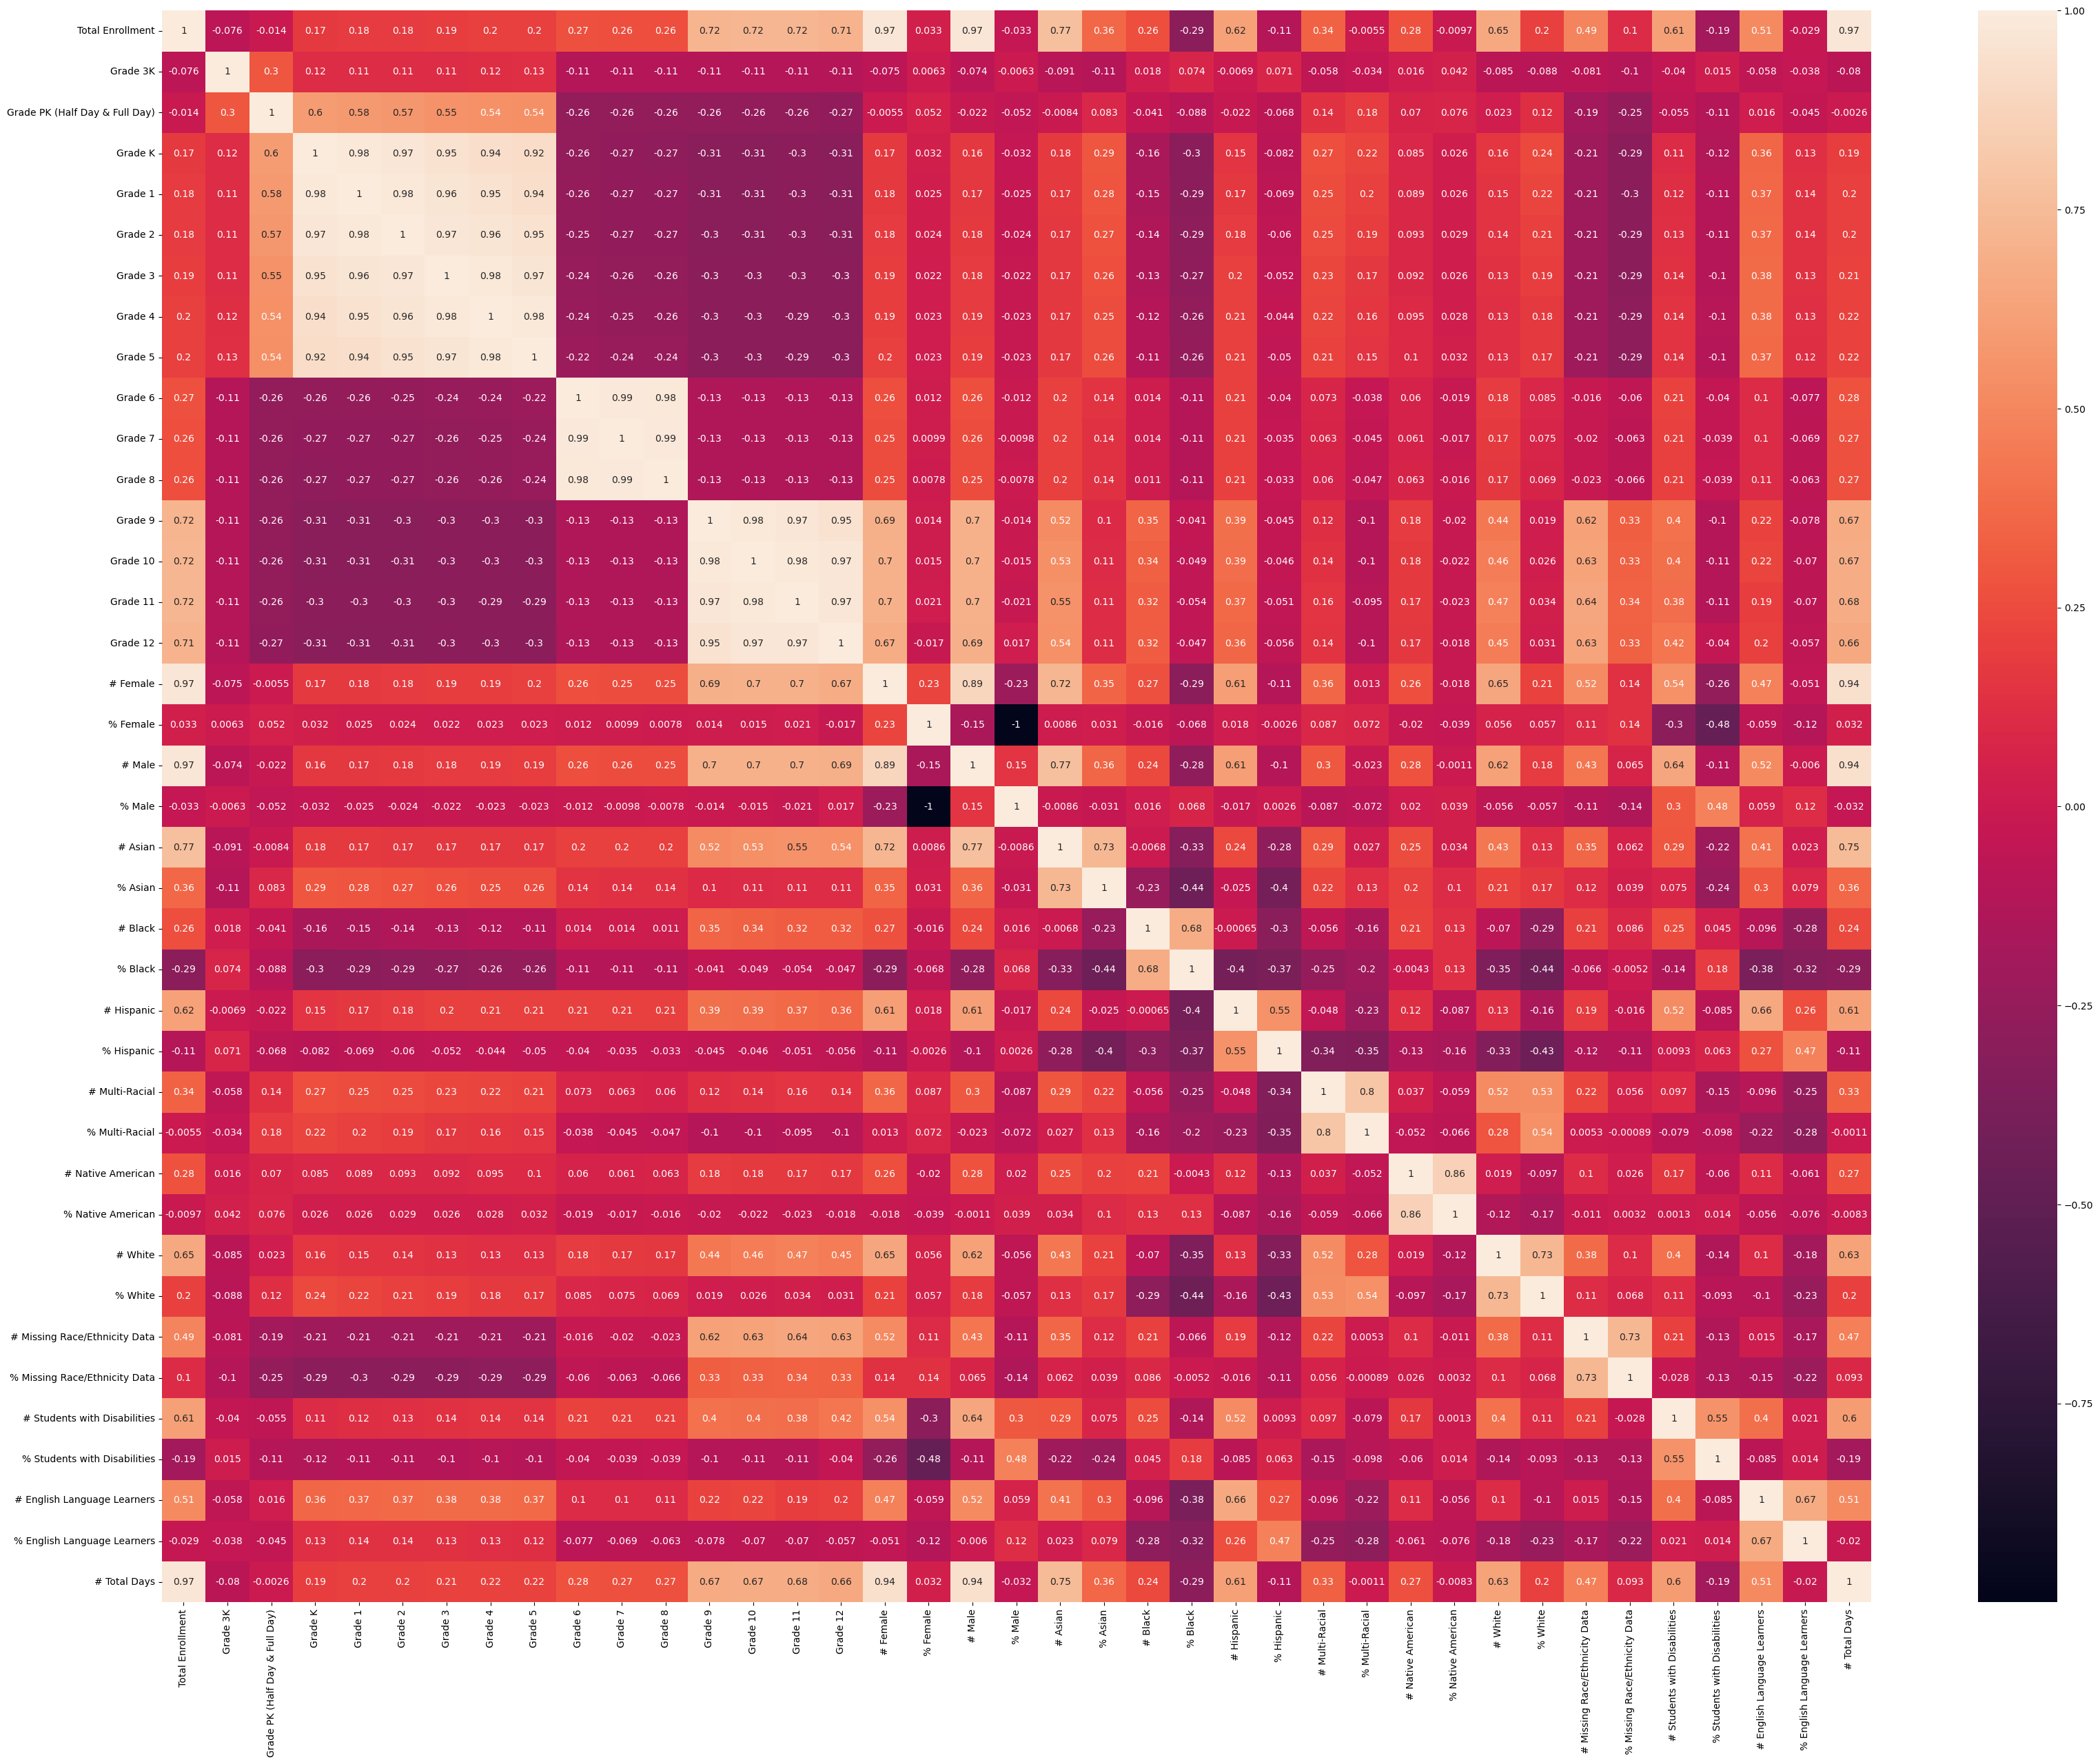

In [253]:
#Heat map of data to check to multicollinearity of dataframe features
plt.figure(figsize=(40, 30))
sns.heatmap(df_merge_1.corr(), annot = True)
plt.show();

Based on the heatmap above I am removing highly collinear features

In [254]:
df_merge_1 = df_merge_1.drop(columns = ["# Poverty", '# Days Absent', '# Days Present', '% Attendance', '# Chronically Absent', '# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial', '# Native American', '# White', '# Missing Race/Ethnicity Data', '# Students with Disabilities', '# English Language Learners', '# Poverty', '# Total Days'], axis = 1)

In addition to dropping collinear features, I will also convert the columns mentioned above to float values

In [255]:
df_merge_1 = df_merge_1.astype({'% Poverty':  float, 'Economic Need Index': float, '% Chronically Absent':float})


ValueError: could not convert string to float: '84.7%'

However, when I tried to convert the values I got error because the objects still have the percent sign. This means that I need to drop the percent sign in each row and change values that say "Above 95%" to 100.0

In [256]:
# transforming columns into floats
df_merge_1['% Poverty'] = df_merge_1['% Poverty'].apply(lambda x: "100.0" if x == 'Above 95%' else x.strip("%"))
df_merge_1['Economic Need Index'] = df_merge_1['Economic Need Index'].apply(lambda x: "100.0" if x == 'Above 95%' else x.strip("%"))
df_merge_1['% Chronically Absent'] = df_merge_1['% Chronically Absent'].apply(lambda x: "100.0" if x == 'Above 95%' else x)
df_merge_1 = df_merge_1.astype({'% Poverty':  float, 'Economic Need Index': float, '% Chronically Absent':float})



# Combined Data EDA

In order to understand my data a bit better, I first want to see how chronic absenteeism has changed over time in NYC. Below I made a graph that shows the average rate of chronic absenteeism per year in nyc. Based on the graph below, we can see that chronic absenteeism has increased since the onset of the pandemic!

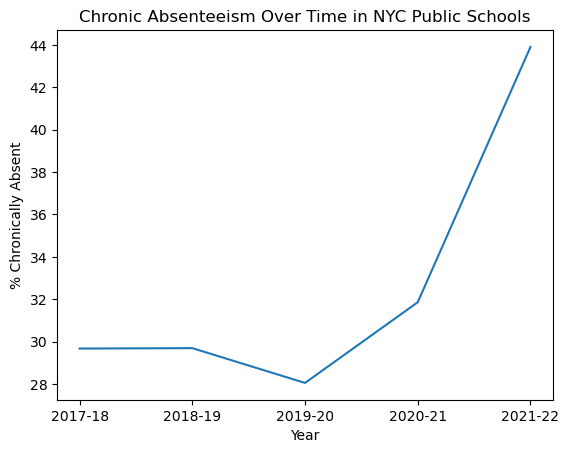

In [257]:
#grouping data by year
group = df_merge_1.groupby("Year").mean()
group.reset_index(inplace = True)

sns.lineplot(data= group, x= "Year", y= "% Chronically Absent")
ax = plt.gca()

# set title
ax.set_title('Chronic Absenteeism Over Time in NYC Public Schools');



Now that we understanding when chronic absenteeism began to spike, we can drop rows that are in a year before 2020. Below I am dropping all rows that are not from the 2020-21 or 2021-22 school year. I am also changing the year from 2020-2021 to 2021 and 2021-22 to 2022.


In [258]:
df_merge_1 = df_merge_1[(df_merge_1["Year"] == '2021-22') | (df_merge_1["Year"] == '2020-21')]
df_merge_1["Year"] = df_merge_1["Year"].apply(lambda x: "2021" if x == "2020-21" else "2022")
df_merge_1

DBN                              School Name  Year  Total Enrollment  \
3     01M015                P.S. 015 Roberto Clemente  2021               193   
4     01M015                P.S. 015 Roberto Clemente  2022               179   
8     01M019                      P.S. 019 Asher Levy  2021               212   
9     01M019                      P.S. 019 Asher Levy  2022               176   
13    01M020                     P.S. 020 Anna Silver  2021               412   
...      ...                                      ...   ...               ...   
7585  75X721     P.S. X721 - Stephen McSweeney School  2022               547   
7589  75X754  J. M. Rapport School Career Development  2021               502   
7590  75X754  J. M. Rapport School Career Development  2022               477   
7594  75X811                                P.S. X811  2021               650   
7595  75X811                                P.S. X811  2022               607   

      Grade 3K  Grade PK (Half Day & Full Day)  Grade K  Grade 1  Grade 2  \
3            0                              17       29       29       27   
4            0                              15       30       26       24   
8            0                              13       23       25       27   
9            9                               7       22       20       22   
13           0                              37       58       52       60   
...        ...                             ...      ...      ...      ...   
7585         0                               0        0        0        0   
7589         0                               0        0        0        0   
7590         0                               0        0        0        0   
7594         0                               0        0        0        0   
7595         0                               0        0        0        0   

      Grade 3  ...  % Hispanic  % Multi-Racial  % Native American  % White  \
3          30  ...       0.528           0.005              0.000    0.057   
4          22  ...       0.520           0.017              0.000    0.067   
8          38  ...       0.613           0.033              0.005    0.080   
9          23  ...       0.574           0.045              0.006    0.119   
13         66  ...       0.522           0.015              0.007    0.073   
...       ...  ...         ...             ...                ...      ...   
7585        0  ...       0.587           0.004              0.009    0.027   
7589        0  ...       0.584           0.002              0.008    0.028   
7590        0  ...       0.593           0.002              0.010    0.029   
7594        0  ...       0.591           0.000              0.020    0.029   
7595        0  ...       0.586           0.002              0.026    0.033   

      % Missing Race/Ethnicity Data  % Students with Disabilities  \
3                             0.000                         0.228   
4                             0.000                         0.212   
8                             0.014                         0.410   
9                             0.017                         0.409   
13                            0.002                         0.223   
...                             ...                           ...   
7585                          0.000                         1.000   
7589                          0.000                         0.998   
7590                          0.000                         0.990   
7594                          0.000                         0.992   
7595                          0.000                         1.000   

      % English Language Learners  % Poverty  Economic Need Index  \
3                           0.109       83.4                 86.4   
4                           0.061       83.8                 87.9   
8                           0.042       71.7                 69.6   
9                           0.034       70.5                 67.8   


Next I want to see how chronic absenteeism changes with race in NYC schools

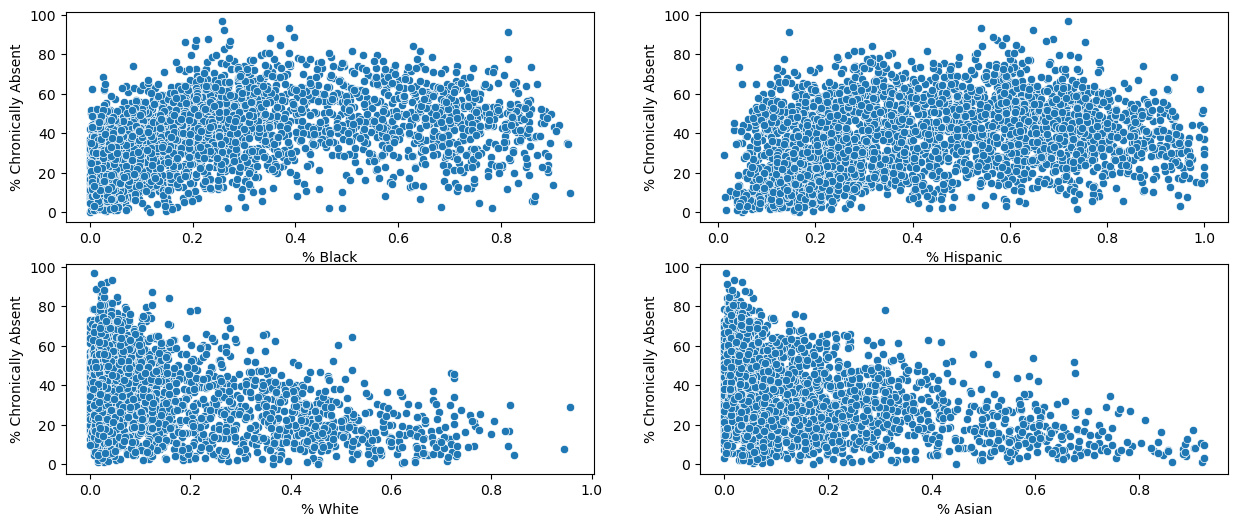

In [259]:
fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))

sns.scatterplot(data=df_merge_1, x="% Black", y="% Chronically Absent", ax = axes[0,0]);
sns.scatterplot(data=df_merge_1, x="% Hispanic", y="% Chronically Absent", ax = axes[0,1]);
sns.scatterplot(data=df_merge_1, x="% White", y="% Chronically Absent", ax = axes[1,0]);
sns.scatterplot(data=df_merge_1, x="% Asian", y="% Chronically Absent", ax = axes[1,1]);

# set title
ax.set_title('Chronic Absenteeism Over Time in NYC Public Schools');

Looking above, we can see that as the percentage of black and hispanic students increase at a school, so does the rate of chronic absenteeism. I also want to see how the rate of poverty at a school impacts absenteeism

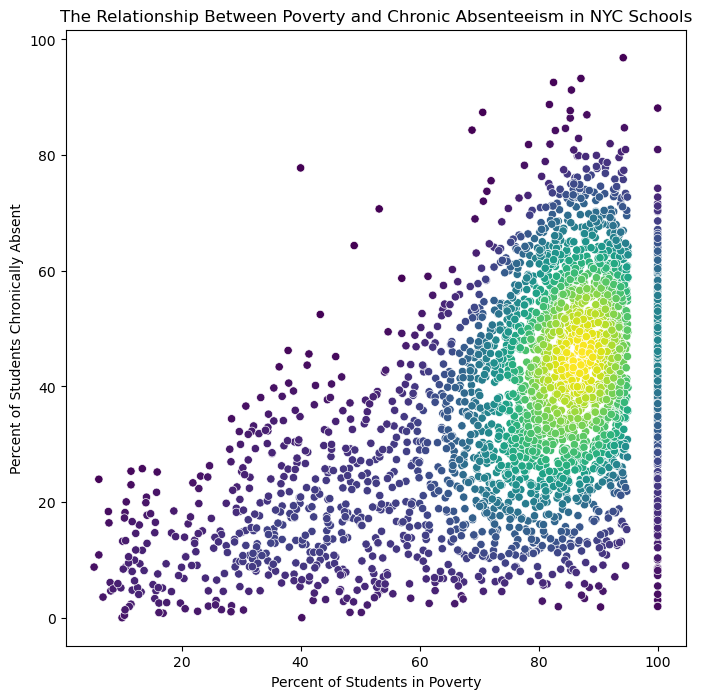

In [222]:
values = np.vstack([df_merge_1["% Poverty"], df_merge_1["% Chronically Absent"]])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    data=df_merge_1,
    x="% Poverty",
    y="% Chronically Absent",
    c=kernel,
    cmap="viridis",
    ax=ax,
)

ax.set_title('The Relationship Between Poverty and Chronic Absenteeism in NYC Schools')
ax.set_xlabel('Percent of Students in Poverty')
ax.set_ylabel('Percent of Students Chronically Absent');


Based on the graph above, we can also see that as the rate of poverty increases at a school, then the rate of absenteeism also increases

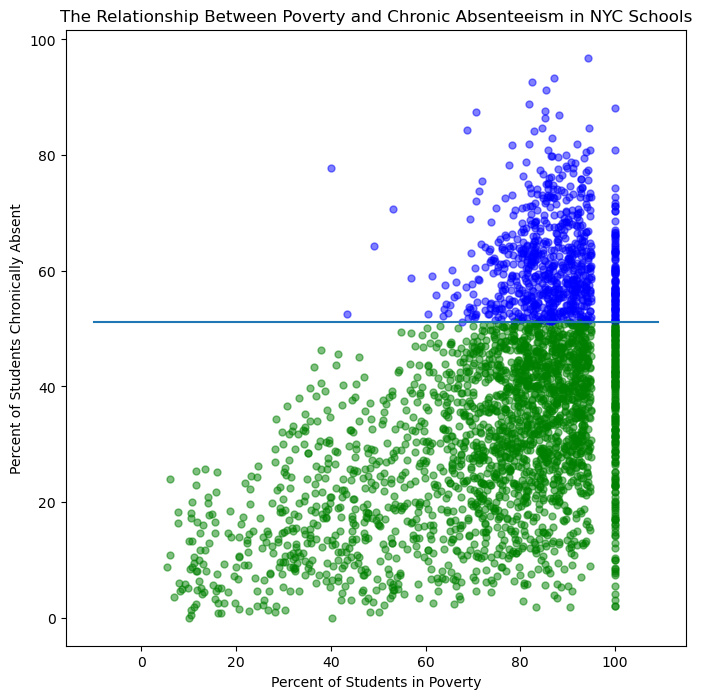

In [223]:
df_merge_1.reset_index(inplace = True)

val = df_merge_1["% Chronically Absent"].quantile(q = 0.75)

fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(x=range(-10,110), y=df_merge_1["% Chronically Absent"].quantile(q = 0.75))

#Iterate over data points and assign colors based on position relative to line
for i in range(len(df_merge_1["% Chronically Absent"])):
    
    if df_merge_1["% Chronically Absent"][i] > val:
        plt.scatter(df_merge_1["% Poverty"][i], df_merge_1["% Chronically Absent"][i], color='blue', marker = 'o', s = 25, alpha = .5)
    
    else:
        plt.scatter(df_merge_1["% Poverty"][i], df_merge_1["% Chronically Absent"][i], color='green', marker = 'o', s = 25, alpha = .5)
        
ax.set_title('The Relationship Between Poverty and Chronic Absenteeism in NYC Schools')
ax.set_xlabel('Percent of Students in Poverty')
ax.set_ylabel('Percent of Students Chronically Absent')

plt.show()

# Adding Additional Features/Measures to My DataSet

Before creating my first (Baseline) model, I am going to add a few more feature columns to my final data set. Specifically, I plan on adding data on the amount of indoor/outdoor space in NYC public schools, Survey Data from Parents and Teachers, and Guidance Counselor data. My hope is that these additional features will help to better categorize my target feature.

In [260]:
#Importing PE Space Data Set
PE_df = pd.read_csv("gen_data/PE_space.csv")

#Dropping unnecessary columns because the main columns I'm interested in is Square Feet and Inside v Outside
PE_df = PE_df.drop(columns = ["Borough", "Geographical  District", "Admin District", "Grade Level", "Bldg ID", "Ownership", "Room Number", "Room Function", "Shared with other schools?", "Space used for any other purpose beside PE", "Location 1"], axis = 1)



In this data set the two columns that I am interested in adding to my final dataset is square feet of space inside and outside the school. With this in mind, lets look at the square Feet feature.

In [261]:
PE_df["Square Feet"]

0        3,243
1       14,953
2        3,942
3       28,121
4        1,080
         ...  
7153     7,722
7154       432
7155     4,960
7156     3,763
7157         -
Name: Square Feet, Length: 7158, dtype: object

Looking at the feature column, most of the numbers have a comma that needs to be removed. In addition, missing data seems to be replaced with a "-". 

In [262]:
#Only 8 values in the feature contain "-", so I will just drop those values
PE_df[PE_df["Square Feet"] == "-"]

ATS Code                                      Location Name  \
2027   10X246                                P.S. 246 Poe Center   
2069   10X315                                P.S. 315 Lab School   
2076   10X340                                           P.S. 340   
2271   10X696  High School of American Studies at Lehman College   
2842   13K595                        Bedford Academy High School   
4685   24Q520  Middle College High School at LaGuardia Commun...   
4687   24Q530  International High School at LaGuardia Communi...   
7157   75X811                                          P.S. X811   

           Bldg Name Square Feet Inside v outside  
2027  LEHMAN COLLEGE           -           Inside  
2069  LEHMAN COLLEGE           -           Inside  
2076  LEHMAN COLLEGE           -           Inside  
2271  LEHMAN COLLEGE           -           Inside  
2842    BEDFORD YMCA           -           Inside  
4685        LIC YMCA           -           Inside  
4687        LIC YMCA           -           Inside  
7157  LEHMAN COLLEGE           -           Inside

In [263]:
#Here I am removing the "," and "-" in the Square Feet Feature and turining the feature into a integer
PE_df["Square Feet"] = PE_df["Square Feet"].apply(lambda x: x.replace(",", ""))
PE_df = PE_df.drop(PE_df[PE_df["Square Feet"] == "-"].index)
PE_df["Square Feet"] = PE_df["Square Feet"].astype(int)

Now that I have transformed the "Square Feet" feature into an integer, I can now calculate the average amount of square feet of indoor and outdoor space per school in NYC

In [264]:
#creating outdoor space df
PE_df_outdoor = PE_df[PE_df["Inside v outside"] == "Outside"]
PE_df_outdoor = PE_df_outdoor.groupby("ATS Code").sum()
PE_df_outdoor.reset_index(inplace = True)
PE_df_outdoor.rename(columns = {"Square Feet": "Outdoor Space (sqft)", "ATS Code": "DBN"}, inplace = True)

#creating indoor space df
PE_df_indoor = PE_df[PE_df["Inside v outside"] == "Inside"]
PE_df_indoor = PE_df_indoor.groupby("ATS Code").sum()
PE_df_indoor.reset_index(inplace = True)
PE_df_indoor.rename(columns = {"Square Feet": "Indoor Space (sqft)", "ATS Code": "DBN"}, inplace = True)
PE_df_indoor

#merging indoor and outdoor Dataframe
PE_df_merge = pd.merge(PE_df_indoor, PE_df_outdoor, on = ["DBN"])

Next I will import 2021 and 2022 survey data from teachers and parents

In [265]:
#Survey Data for teachers (2021)
teacher_21 = pd.read_csv("survey_data/Teacher_Survey_2021.csv")
teacher_21 = teacher_21.drop(columns = ["Early Childhood Instruction"], axis =1)
teacher_21["DBN"] = teacher_21["Name"].apply(lambda x: x[0:6])
teacher_21["Name"] = teacher_21["Name"].apply(lambda x: x[9: ])
teacher_21["Year"] = "2021"
teacher_21 = teacher_21[['DBN', 'Name', "Year", 'Academic Press', 'Classroom Behavior',
       'Cultural Awareness and Inclusive Classroom Instruction', 'Guidance',
       'Innovation and Collective Responsibility', 'Instructional Leadership',
       'Outreach to Parents', 'Peer Collaboration', 'Program Coherence',
       'Quality of Professional Development', 'Quality of Student Discussion',
       'Safety', 'School Commitment', 'Social-Emotional',
       'Strong Core Instruction', 'Teacher Influence',
       'Teacher-Principal Trust', 'Teacher-Teacher Trust']]

#Survey Data for teachers (2022)
teacher_22 = pd.read_csv("survey_data/Teacher_Survey_2022.csv")
teacher_22["DBN"] = teacher_22["Name"].apply(lambda x: x[0:6])
teacher_22["Name"] = teacher_22["Name"].apply(lambda x: x[9: ])
teacher_22["Year"] = "2022"
teacher_22 = teacher_22[['DBN', 'Name', "Year", 'Academic Press', 'Classroom Behavior',
       'Cultural Awareness and Inclusive Classroom Instruction', 'Guidance',
       'Innovation and Collective Responsibility', 'Instructional Leadership',
       'Outreach to Parents', 'Peer Collaboration', 'Program Coherence',
       'Quality of Professional Development', 'Quality of Student Discussion',
       'Safety', 'School Commitment', 'Social-Emotional',
       'Strong Core Instruction', 'Teacher Influence',
       'Teacher-Principal Trust', 'Teacher-Teacher Trust']]


#Concating Teacher Survey Data
teacher_df = pd.concat([teacher_22, teacher_21])
teacher_df.sort_values("DBN", ascending = True, inplace = True)
teacher_df.reset_index(drop = True, inplace = True)
teacher_df.rename(columns = {'Name': 'School Name', 'Outreach to Parents': 'Outreach to Parents(T)'}, inplace = True)

#Survey Data for family (2021)
family_21 = pd.read_csv("survey_data/Families_Survey_2021.csv")
family_21["DBN"] = family_21["Name"].apply(lambda x: x[0:6])
family_21["Name"] = family_21["Name"].apply(lambda x: x[9: ])
family_21["Year"] = "2021"
family_21 = family_21[['DBN','Name', 'Year', 'Inclusive Leadership', 'Outreach to Parents',
       'Parent Involvement in School', 'Parent-Principal Trust',
       'Parent-Teacher Trust']]


#Survey Data for family (2022)
family_22 = pd.read_csv("survey_data/Families_Survey_2022.csv")
family_22["DBN"] = family_22["Name"].apply(lambda x: x[0:6])
family_22["Name"] = family_22["Name"].apply(lambda x: x[9: ])
family_22["Year"] = "2022"
family_22 = family_22[['DBN','Name', 'Year', 'Inclusive Leadership', 'Outreach to Parents',
       'Parent Involvement in School', 'Parent-Principal Trust',
       'Parent-Teacher Trust']]

#Concating family survey data
family_df = pd.concat([family_22, family_21])
family_df.sort_values("DBN", ascending = True, inplace = True)
family_df.reset_index(drop = True, inplace = True)
family_df.rename(columns = {'Name': 'School Name', 'Outreach to Parents': 'Outreach to Parents(F)'}, inplace = True)
family_df

DBN                                        School Name  Year  \
0     01M015                          P.S. 015 Roberto Clemente  2022   
1     01M015                          P.S. 015 Roberto Clemente  2021   
2     01M019                                P.S. 019 Asher Levy  2022   
3     01M019                                P.S. 019 Asher Levy  2021   
4     01M020                               P.S. 020 Anna Silver  2022   
...      ...                                                ...   ...   
5371  Z149 -     E RICHMOND PRE-K CENTER AT 375 TOMPKINS AVENUE  2022   
5372  Z150 -       E RICHMOND PRE-K CENTER AT 2389 RICHMOND AVE  2022   
5373  Z151 -   E RICHMOND PRE-K CENTER AT 1800 RICHMOND TERRACE  2022   
5374  Z152 -  RDEN OF LEARNING AND DISCOVERY PRE-K CENTER AT...  2022   
5375  Z152 -  RDEN OF LEARNING AND DISCOVERY PRE-K CENTER AT...  2021   

      Inclusive Leadership  Outreach to Parents(F)  \
0                     90.0                    93.0   
1                     97.0                    98.0   
2                     72.0                    91.0   
3                     96.0                    98.0   
4                     98.0                    97.0   
...                    ...                     ...   
5371                 100.0                    97.0   
5372                  93.0                    96.0   
5373                 100.0                   100.0   
5374                 100.0                   100.0   
5375                 100.0                   100.0   

      Parent Involvement in School  Parent-Principal Trust  \
0                             86.0                    92.0   
1                             87.0                    98.0   
2                             89.0                    71.0   
3                             94.0                    97.0   
4                             91.0                    97.0   
...                            ...                     ...   
5371                          88.0                    95.0   
5372                          94.0                    89.0   
5373                          95.0                   100.0   
5374                         100.0                   100.0   
5375                         100.0                   100.0   

      Parent-Teacher Trust  
0                     93.0  
1                     96.0  
2                     86.0  
3                     97.0  
4                     98.0  
...                    ...  
5371                  99.0  
5372                  97.0  
5373                 100.0  
5374                 100.0  
5375                 100.0  

[5376 rows x 8 columns]

The last data I will add to my dataframe is school counselor data from 2021 and 2022

In [266]:
#Guidance Counselor and Social Work Data
df_guidance_2021 = pd.read_csv("gen_data/guidance_21.csv")
df_guidance_2022 = pd.read_csv("gen_data/guidance_22.csv")

#Drop Nan Values
df_guidance_2021.dropna(inplace = True)
df_guidance_2022.dropna(inplace = True)

#adding year column
df_guidance_2021["Year"] = "2021"
df_guidance_2022["Year"] = "2022"

#dropping columns
df_guidance_2021 = df_guidance_2021[["DBN", "Total Guidance Counselors (GC) & Social Workers (SW)\n\n\n(includes GCs, SWs, ATRs, School Response Clinicians, High Needs Counselors, High Need SWs, Single Shepherds, Bridging the Gap SWs)", "Year"]]
df_guidance_2021.rename(columns = {"Total Guidance Counselors (GC) & Social Workers (SW)\n\n\n(includes GCs, SWs, ATRs, School Response Clinicians, High Needs Counselors, High Need SWs, Single Shepherds, Bridging the Gap SWs)": "Number of Counselors"}, inplace = True)
df_guidance_2022 = df_guidance_2022[["DBN", "Total Guidance Counselors (GC) & Social Workers (SW)\n\n\n(includes GCs, SWs, ATRs, School Response Clinicians, High Needs Counselors, High Need SWs, Single Shepherds, Bridging the Gap SWs)", "Year"]]
df_guidance_2022.rename(columns = {"Total Guidance Counselors (GC) & Social Workers (SW)\n\n\n(includes GCs, SWs, ATRs, School Response Clinicians, High Needs Counselors, High Need SWs, Single Shepherds, Bridging the Gap SWs)": "Number of Counselors"}, inplace = True)

#Combining and organizing guidance counselor data from 2021 and 2022
counselor_concat = pd.concat([df_guidance_2022, df_guidance_2021])
counselor_concat.sort_values("DBN", ascending = True, inplace = True)

#Replacing Missing values
counselor_concat.loc[counselor_concat["DBN"] == '04M310', 'Number of Counselors'] = 6.0
counselor_concat.loc[counselor_concat["Number of Counselors"] == 'Has counseling service (outside provider)', 'Number of Counselors'] = 1.0
counselor_concat.loc[counselor_concat["Number of Counselors"] == '5 school psychologists providing counseling services', 'Number of Counselors'] = 5.0
counselor_concat.loc[counselor_concat["Number of Counselors"] == '4 full-time school psychologists providing counseling services', 'Number of Counselors'] = 4.0
counselor_concat.loc[counselor_concat["Number of Counselors"] == '3 full-time school psychologists providing counseling services', 'Number of Counselors'] = 3.0
counselor_concat.loc[counselor_concat["Number of Counselors"] == '2 full-time school psychologists providing counseling services', 'Number of Counselors'] = 2.0

#Dropping missing values that can't be imputed
counselor_concat = counselor_concat.drop(counselor_concat[counselor_concat["Number of Counselors"] == 'In progress (interviewing)'].index)
counselor_concat = counselor_concat.drop(counselor_concat[counselor_concat["Number of Counselors"] == 'New school and small enrollment'].index)

#transforming "Number of Counselors" data into a float
counselor_concat["Number of Counselors"] = counselor_concat["Number of Counselors"].astype(float)



In [267]:
#Merging all Data Sets
df_merge_2 = pd.merge(df_merge_1, PE_df_merge, on = ['DBN'])
df_merge_3 = pd.merge(df_merge_2, teacher_df, on = ['DBN', "School Name", 'Year'])
df_merge_4 = pd.merge(df_merge_3, family_df, on = ['DBN', "School Name", 'Year'])
df_final = pd.merge(df_merge_4, counselor_concat, on = ['DBN', 'Year'])



Now that I have my final data frame, let's check the number of school I have. 

In [272]:
print(df_final["DBN"].value_counts())

P.S. 360                            4
P.S. 239                            2
P.S. 81Q Jean Paul Richter          2
P.S./I.S. 087 Middle Village        2
P.S. 088 Seneca                     2
                                   ..
Dr. Jacqueline Peek-Davis School    1
The School For Future Leaders       1
P.S. 138 Brooklyn                   1
M.S. 246 Walt Whitman               1
P.S. 015 Roberto Clemente           1
Name: School Name, Length: 960, dtype: int64
19K224    2
24Q293    2
24Q087    2
24Q088    2
24Q091    2
         ..
17K012    1
20K310    1
17K138    1
17K246    1
01M015    1
Name: DBN, Length: 961, dtype: int64


My initial dataframe had 1527 schools, but after all the data merging I only have 961 unique schools. 

In [233]:
#Creating Borough and School District Columns
df_final["Borough"] = df_final["DBN"].apply(lambda x: x[2:3])
df_final["School District"] = df_final["DBN"].apply(lambda x: x[0:2])
df_final.drop(columns = ["DBN"], axis = 1, inplace = True)

Let's take a look at the final data frame:

In [234]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889 entries, 0 to 1888
Data columns (total 62 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   index                                                   1889 non-null   int64  
 1   School Name                                             1889 non-null   object 
 2   Year                                                    1889 non-null   object 
 3   Total Enrollment                                        1889 non-null   int64  
 4   Grade 3K                                                1889 non-null   int64  
 5   Grade PK (Half Day & Full Day)                          1889 non-null   int64  
 6   Grade K                                                 1889 non-null   int64  
 7   Grade 1                                                 1889 non-null   int64  
 8   Grade 2                               

In the final data frame a few values are missing. Most missing values occur in the "strong core instruction" feature. In addition, I am also going to replace the indoor and outspace columns with indoor/outdoor space per capita columns.

In [235]:
#Calculating per capita
df_final["Indoor Space Per Capita"] = df_final['Indoor Space (sqft)']/df_final['Total Enrollment']
df_final["Outdoor Space Per Capita"] = df_final['Outdoor Space (sqft)']/df_final['Total Enrollment']

In [236]:
#dropping outdoor and indoor space
df_final.drop(columns = ['Indoor Space (sqft)', 'Outdoor Space (sqft)'], axis = 1, inplace = True)

In [237]:
#Filling Missing Data in the "Srong Core Instruction" Column
df_final.loc[df_final['School Name'] == 'P.S. 149 Sojourner Truth', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'Central Park East I', 'Strong Core Instruction'] = 92.0
df_final.loc[df_final['School Name'] == 'Hamilton Grange Middle School', 'Strong Core Instruction'] = 92.0
df_final.loc[df_final['School Name'] == 'City College Academy of the Arts', 'Strong Core Instruction'] = 96.0
df_final.loc[df_final['School Name'] == 'M.S. 324 - Patria Mirabal', 'Strong Core Instruction'] = 99.0
df_final.loc[df_final['School Name'] == "Women's Academy of Excellence", 'Strong Core Instruction'] = 98.0
df_final.loc[df_final['School Name'] == 'Bronx Health Sciences High School', 'Strong Core Instruction'] = 89.0
df_final.loc[df_final['School Name'] == 'P.S. 044 Marcus Garvey', 'Strong Core Instruction'] = 97.0
df_final.loc[df_final['School Name'] == 'M.S. 113 Ronald Edmonds Learning Center', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'M.S. K266 - Park Place Community Middle School', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'The Urban Assembly Unison School', 'Strong Core Instruction'] = 93.0
df_final.loc[df_final['School Name'] == 'Fort Greene Preparatory Academy', 'Strong Core Instruction'] = 98.0
df_final.loc[df_final['School Name'] == 'Whitelaw Reid Academy of Arts and Business', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'I.S. 340', 'Strong Core Instruction'] = 98.0
df_final.loc[df_final['School Name'] == 'Elijah Stroud Middle School', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'Ronald Edmonds Learning Center II', 'Strong Core Instruction'] = 100.0
df_final.loc[df_final['School Name'] == 'P.S. 268 Emma Lazarus', 'Strong Core Instruction'] = 98.0
df_final.loc[df_final['School Name'] == 'P.S. 279 Herman Schreiber', 'Strong Core Instruction'] = 94.0
df_final.loc[df_final['School Name'] == 'P.S. 202 Ernest S. Jenkyns', 'Strong Core Instruction'] = 93.0
df_final.loc[df_final['School Name'] == 'International High School at Lafayette', 'Strong Core Instruction'] = 95.0



In [238]:
#dropping remaining NaN values that could not be filled
df_final = df_final.dropna()
df_final.drop("index", axis = 1, inplace = True)

Checking our heatmap one last time for collinearity

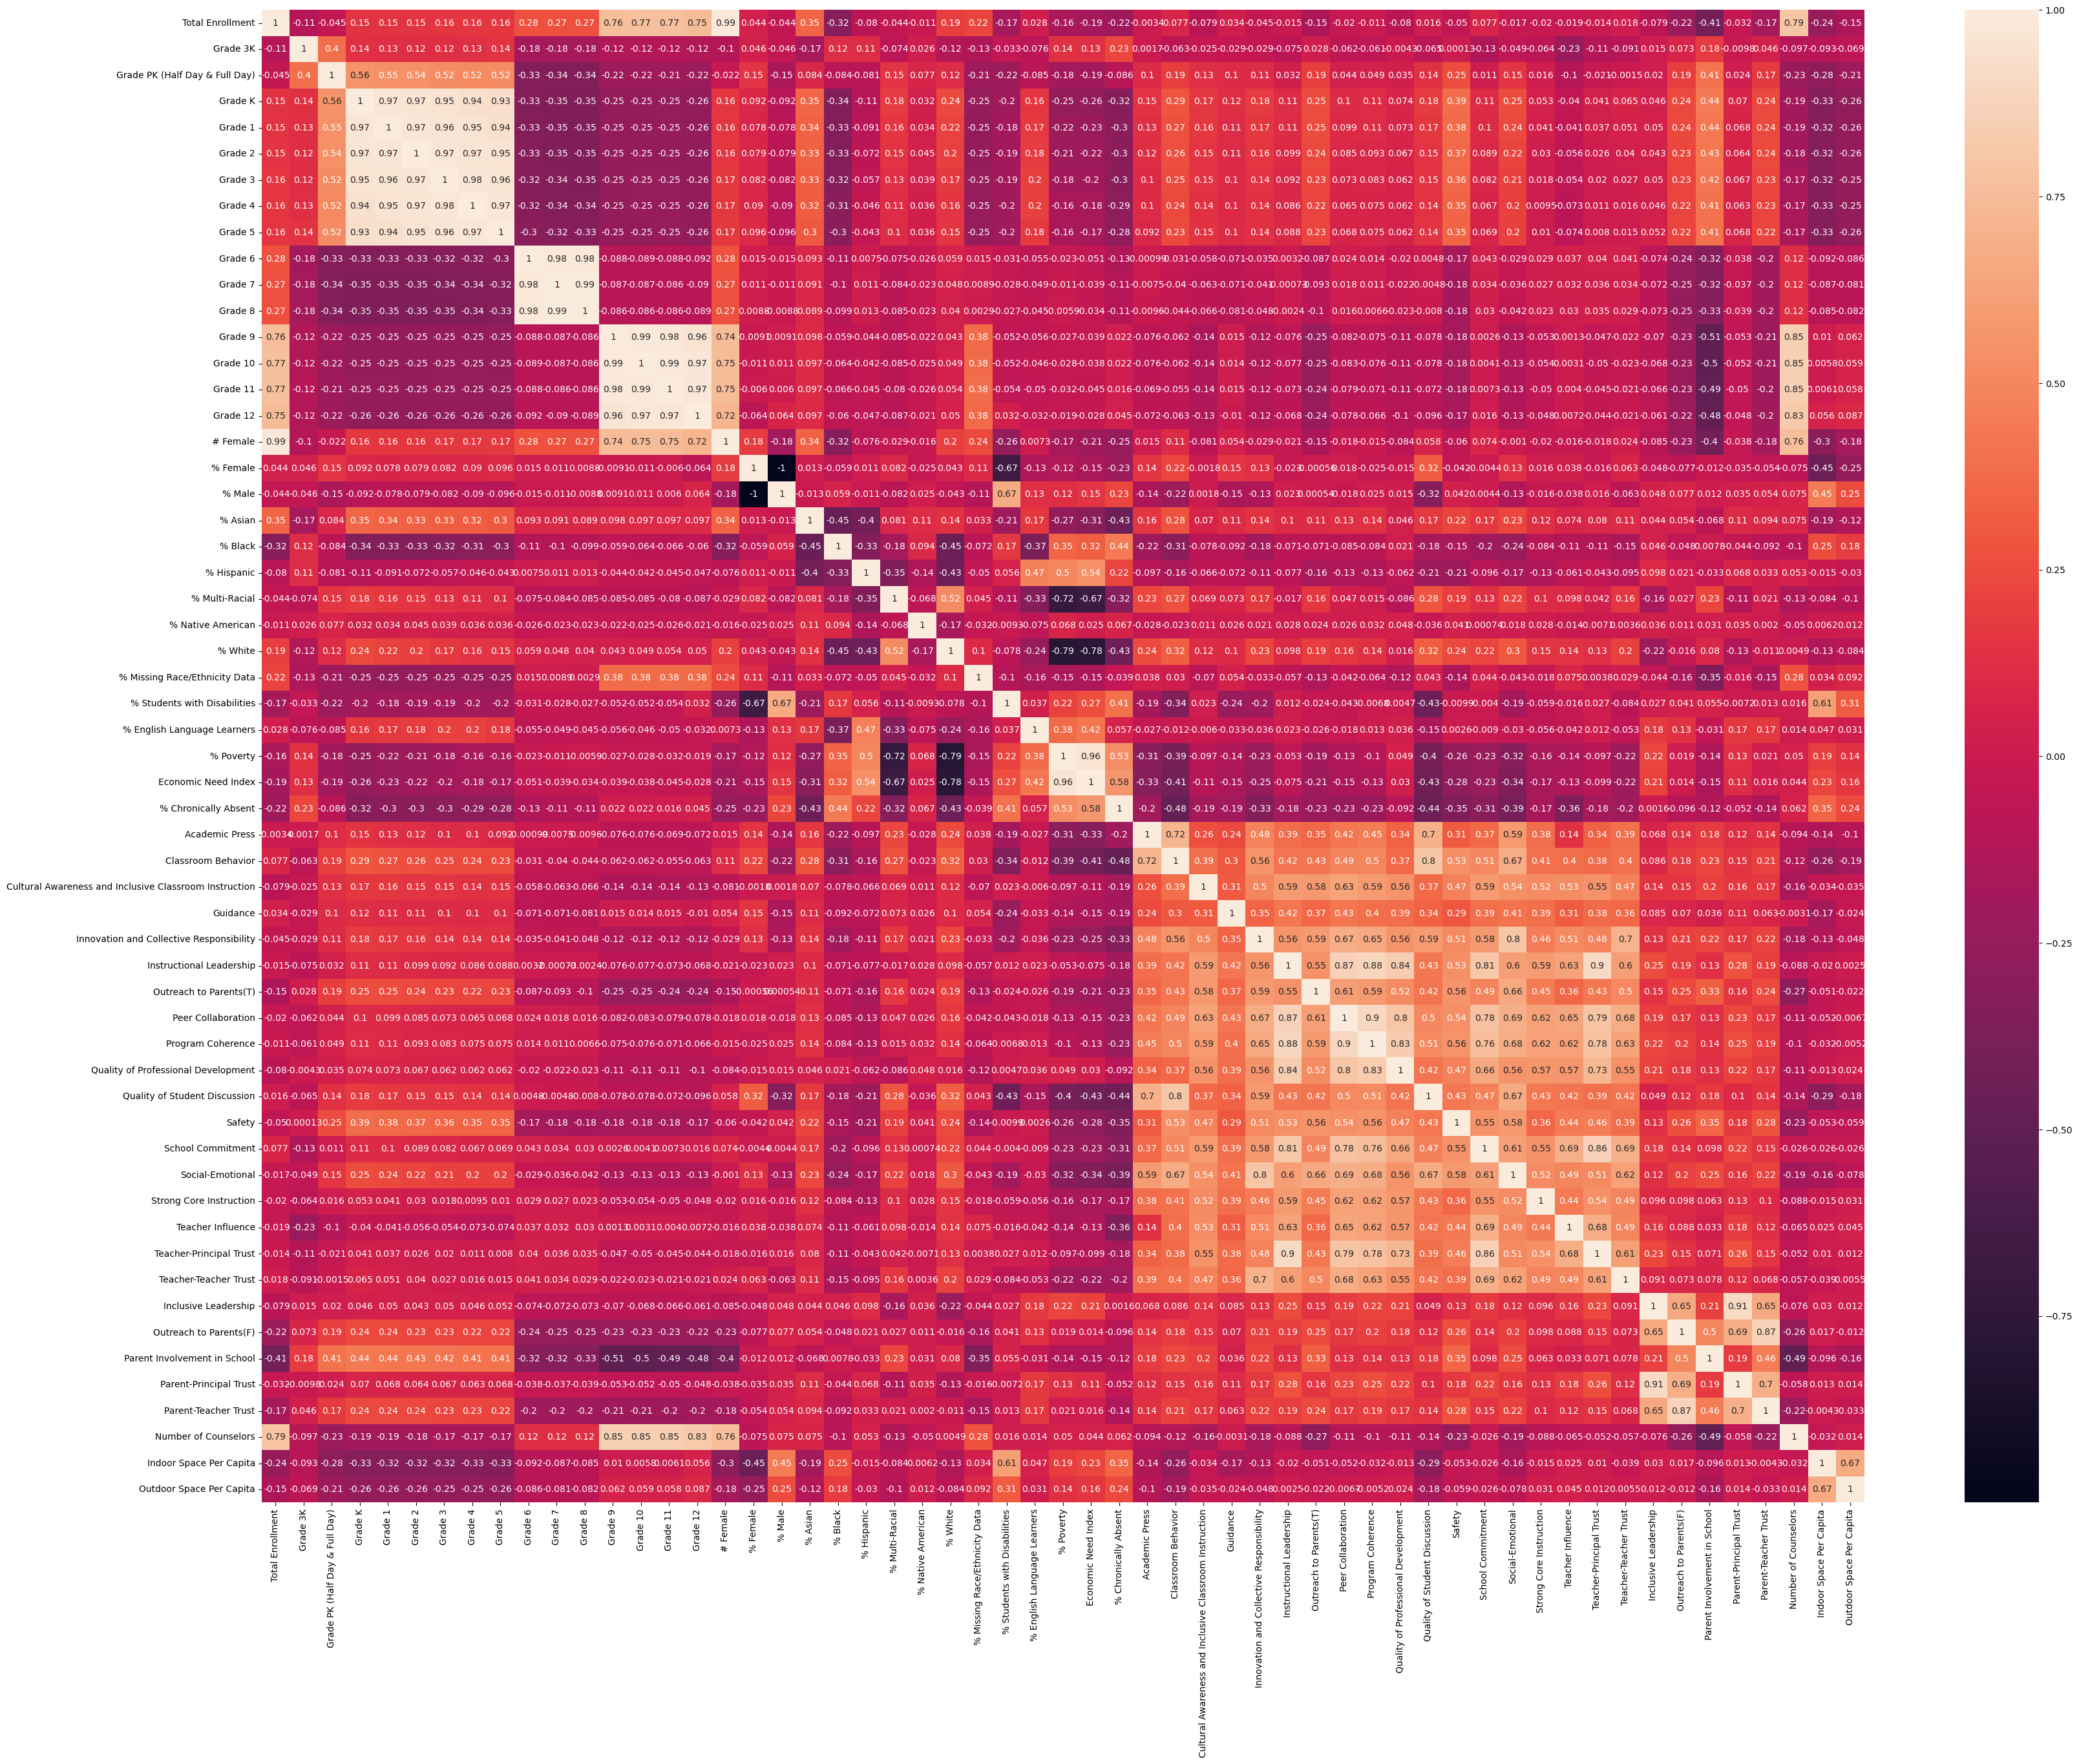

In [239]:
plt.figure(figsize=(40, 30))
sns.heatmap(df_final.corr(), annot = True)
plt.show();

# Train Test Split

Now it is time to split our data into a train and a test. My y value is my target variable, which is the percent of chronically absent students at a school in New York's Public School System. I will make this feature a binary category by assigning the value of 1 to schools in the top 25% of chronically absent students and 0 to the bottom 75%. 

In [240]:
y = df_final['% Chronically Absent']
y = y.apply(lambda x: 0 if x < y.quantile(q = 0.75) else 1)
X = df_final.drop(columns = ['% Chronically Absent'], axis = 1)

# Perform train-test split with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [241]:
#My targets are not evenly distributed, which means I have a class imbalance
y.value_counts()


0    1401
1     468
Name: % Chronically Absent, dtype: int64

# Creating My Models

Below I will use the X_train and y_train data to create mutliple categorizing models. I will assess these models based on the recall score. I decided to use recall instead of precision or accuracy scores to assess my models because I feel like my stakeholder (the Department of Education) will want to the lowest number of false negatives possible. If recall is about the same between models, I will then look at precision to ensure that the number of false positives are also low.

In addition, I will need to use SMOTE and the imblearn pipline in my categorization models because I have a class imbalance

### Logistic Regression (Baseline)

In [41]:
#logistic Regression Baseline
legreg = LogisticRegression(random_state=42)
sm = SMOTE(random_state=42)


#column transformations
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore', sparse = False, drop = 'first'))])


#selecting columns
num_cols = X_train.select_dtypes(['int', 'float']).columns

ct = ColumnTransformer([
    
     ("nominalpipe", nominal_pipeline, ['Borough', 'School District']),
     ("numpipe", numeric_pipeline, num_cols)

])

pipeline = Pipeline(steps = [('ct', ct), ("smote", sm), ('model', legreg)])

pipeline.fit(X_train, y_train)

pipeline.score(X_test, y_test)

0.811965811965812

Test Score: 0.811965811965812
Train Score: 0.8344039971448965
Recall Test Score: 0.8294573643410853
Recall Train Score: 0.8289085545722714
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       339
           1       0.62      0.83      0.71       129

    accuracy                           0.81       468
   macro avg       0.77      0.82      0.78       468
weighted avg       0.84      0.81      0.82       468



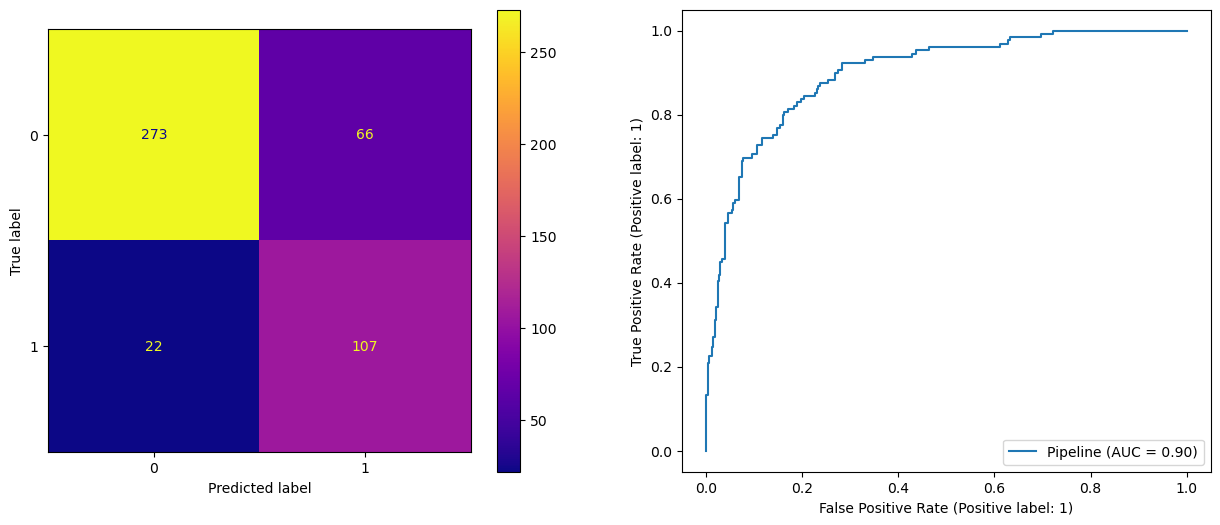

In [42]:
#Accuracy Scores
from sklearn.metrics import recall_score
print("Test Score: {}".format(pipeline.score(X_test, y_test)))
print("Train Score: {}".format(pipeline.score(X_train, y_train)))

#cross validation score
#print("cross validation: {}".format(cross_val_score(pipeline, X_train, y_train)))

#y predictions
y_pred = pipeline.predict(X_test)
y_pred_t = pipeline.predict(X_train) 

#Recall Scores
print("Recall Test Score: {}".format(recall_score(y_test, y_pred)))
print("Recall Train Score: {}".format(recall_score(y_train, y_pred_t)))

#Evaluating Logistic Regression
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap="plasma", ax=axes[0])

#ROC Curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=axes[1])

#Classification Report
print(classification_report(y_test, y_pred))



Looking at the baseline model, the model is overall pretty good but there is a bit of over fitting because the accuracy train score is better than the accuracy test score. Next I will also look at a decision tree model and another logistic regression model using parameter tuning. 

### Decision Tree Model

In [43]:
#Decision Tree Model
rf_clf = DecisionTreeClassifier(random_state=42)
sm = SMOTE(random_state=42)


#column transformations
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore', sparse = False))])
    

#selecting columns
num_cols = X_train.select_dtypes(['int', 'float']).columns

ct = ColumnTransformer([
    
     ("nominalpipe", nominal_pipeline, ['Borough', 'School District']),
     ("numpipe", numeric_pipeline, num_cols)

])

pipeline_dt = Pipeline(steps = [('ct', ct), ("smote", sm), ('model', rf_clf)])

pipeline_dt_grid = { 
            'smote__sampling_strategy': ['minority', 'not minority', 'not majority', 'all'],
             'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
             'model__min_samples_split': [2, 4, 6, 8, 10, 12],
}

gs_pipeline_dt = GridSearchCV(estimator= pipeline_dt, 
                       param_grid=pipeline_dt_grid, scoring = "recall", cv = 5)

gs_pipeline_dt.fit(X_train, y_train)

print(gs_pipeline_dt.best_params_)

gs_pipeline_dt.best_estimator_


{'model__max_depth': 1, 'model__min_samples_split': 2, 'smote__sampling_strategy': 'minority'}


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Borough',
                                                   'School District']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Total Enrollment', 'Grade 3K', 'Grade PK (Half Day & Full Day)',
       'Grade K', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'G...
       'Teacher-Principal Trust', 'Teacher-Teacher Trust',
       'Inclusive Leadership', 'Outreach to Parents(F)',
       'Parent Involvement in School', 'Parent-Principal Trust',
       'Parent-Teacher Trust', 'Number of Counselors',
       'Indoor Space Per Capita', 'Outdoor Space Per Capita'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('model',
                 DecisionTreeClassifier(max_depth=1, random_state=42))])

Test Score: 0.9069767441860465
Train Score: 0.8938053097345132
              precision    recall  f1-score   support

           0       0.94      0.53      0.67       339
           1       0.42      0.91      0.57       129

    accuracy                           0.63       468
   macro avg       0.68      0.72      0.62       468
weighted avg       0.79      0.63      0.65       468



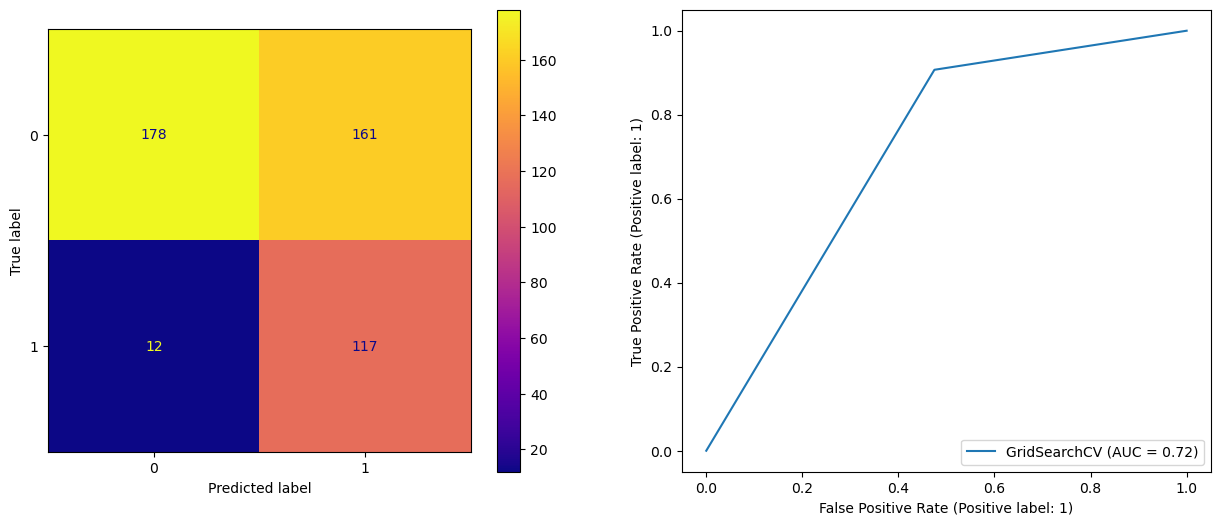

In [44]:
#score
print("Test Score: {}".format(gs_pipeline_dt.score(X_test, y_test)))
print("Train Score: {}".format(gs_pipeline_dt.score(X_train, y_train)))

#cross validation score
#print("cross validation: {}".format(cross_val_score(gs_pipeline_dt, X_train, y_train)))

#y predictions
y_pred = gs_pipeline_dt.predict(X_test) 

#Evaluating Logistic Regression
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(gs_pipeline_dt, X_test, y_test, cmap="plasma", ax=axes[0])

#ROC Curve
RocCurveDisplay.from_estimator(gs_pipeline_dt, X_test, y_test, ax=axes[1])

#Classification Report
print(classification_report(y_test, y_pred))

The scores for the decision tree are better than my baseline. The recall score is 0.91.

### Logistic Regression with Parameter Tuning Using GridSearchCV

In [45]:
#Logistic Regression Model
legreg = LogisticRegression(random_state =42)
sm = SMOTE(random_state=42)


#column transformations
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore', sparse = False, drop = 'first'))])
    

#selecting columns
num_cols = X_train.select_dtypes(['int', 'float']).columns

ct = ColumnTransformer([
    
     ("nominalpipe", nominal_pipeline, ['Borough', 'School District']),
     ("numpipe", numeric_pipeline, num_cols)

])

pipeline_lg = Pipeline(steps = [('ct', ct), ("smote", sm), ('model', legreg)])

pipeline_lg_grid = { 
    'smote__sampling_strategy': ['minority', 'not minority', 'not majority', 'all'],
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [1, 10, 100, 1000, 10000, 100000, 1000000], 
    'model__solver': ["lbfgs", 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    "model__max_iter": [1, 10, 100, 1000, 10000]

}

gs_pipeline_lg = GridSearchCV(estimator= pipeline_lg, 
                       param_grid=pipeline_lg_grid, scoring = "recall", cv = 5)

gs_pipeline_lg.fit(X_train, y_train)

print(gs_pipeline_lg.best_params_)


{'model__C': 1, 'model__max_iter': 1, 'model__penalty': 'l1', 'model__solver': 'saga', 'smote__sampling_strategy': 'minority'}


Test Score: 0.9069767441860465
Train Score: 0.887905604719764
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       339
           1       0.54      0.91      0.68       129

    accuracy                           0.76       468
   macro avg       0.75      0.81      0.75       468
weighted avg       0.84      0.76      0.78       468



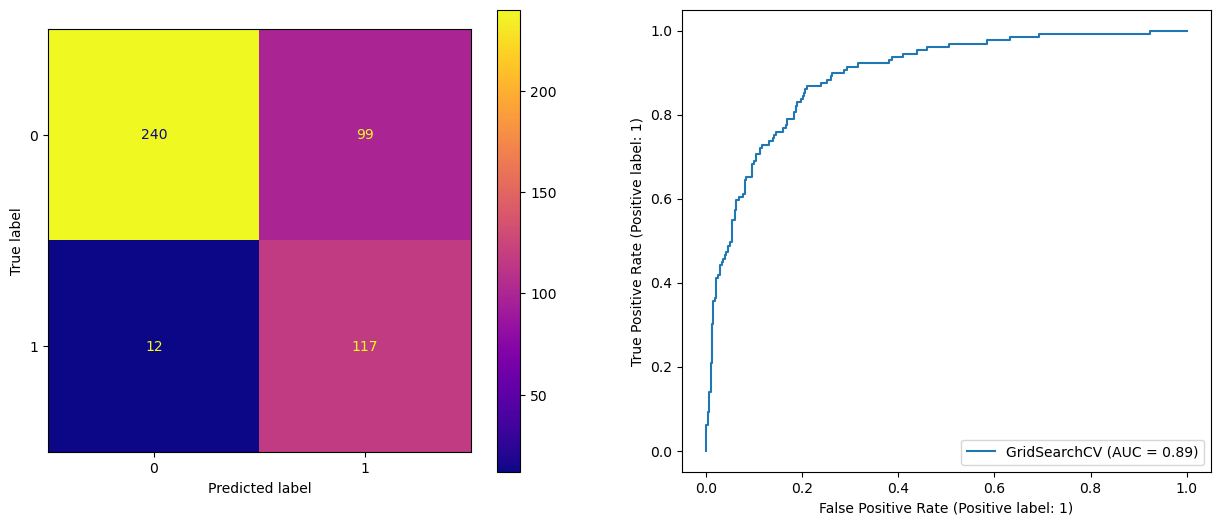

In [46]:
#score
print("Test Score: {}".format(gs_pipeline_lg.score(X_test, y_test)))
print("Train Score: {}".format(gs_pipeline_lg.score(X_train, y_train)))

#cross validation score
#print("cross validation: {}".format(cross_val_score(gs_pipeline_lg, X_train, y_train)))

#y predictions
y_pred = gs_pipeline_lg.predict(X_test) 

#Evaluating Logistic Regression
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(gs_pipeline_lg, X_test, y_test, cmap="plasma", ax=axes[0])

#ROC Curve
RocCurveDisplay.from_estimator(gs_pipeline_lg, X_test, y_test, ax=axes[1])

#Classification Report
print(classification_report(y_test, y_pred))

The logistic regression with parameter tuning has a recall score of 0.91, which is the same as the decision tree model. However, I feel like this model is better than the decision tree model because the accuracy and precision are higher for this model. As a result, I will use this model for my final model. 

# Final Model

For my final model, I looked at the best parameters from my parameter tuning logistic regression model and used those parameters for my final model.

In [47]:
#Final Model
ss = StandardScaler()
ohe =  OneHotEncoder()
legreg = LogisticRegression(C = 1, max_iter = 1, penalty = 'l1', solver = 'saga', random_state = 42)
sm = SMOTE(random_state=42, sampling_strategy = 'minority')


#column transformations
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore', sparse = False, drop = 'first'))])
    

#selecting columns
num_cols = X_train.select_dtypes(['int', 'float']).columns

ct = ColumnTransformer([
    
     ("nominalpipe", nominal_pipeline, ['Borough', 'School District']),
     ("numpipe", numeric_pipeline, num_cols)

])

pipeline_lg_final = Pipeline(steps = [('ct', ct), ("smote", sm), ('model', legreg)])


pipeline_lg_final.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Borough',
                                                   'School District']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Total Enrollment', 'Grade 3K', 'Grade PK (Half Day & Full Day)',
       'Grade K', 'Grade 1', 'Grade 2', 'Grade 3...
       'Inclusive Leadership', 'Outreach to Parents(F)',
       'Parent Involvement in School', 'Parent-Principal Trust',
       'Parent-Teacher Trust', 'Number of Counselors',
       'Indoor Space Per Capita', 'Outdoor Space Per Capita'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('model',
                 LogisticRegression(C=1, max_iter=1, penalty='l1',
                                    random_state=42, solver='saga'))])

Test Score: 0.7628205128205128
Train Score: 0.7480371163454675
Recall Test Score: 0.9069767441860465
Recall Train Score: 0.887905604719764
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       339
           1       0.54      0.91      0.68       129

    accuracy                           0.76       468
   macro avg       0.75      0.81      0.75       468
weighted avg       0.84      0.76      0.78       468



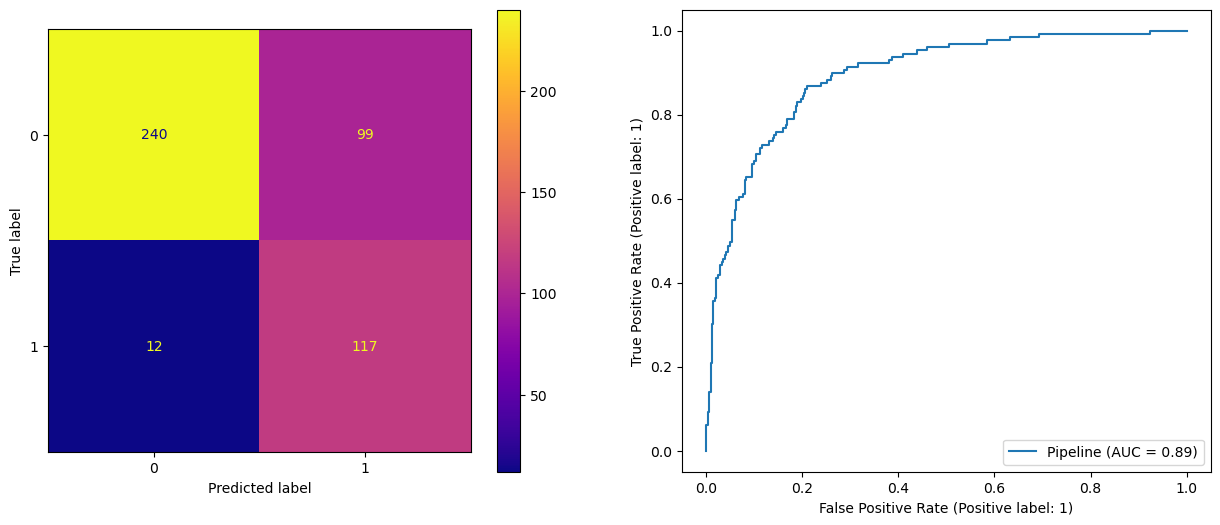

In [48]:
#score
print("Test Score: {}".format(pipeline_lg_final.score(X_test, y_test)))
print("Train Score: {}".format(pipeline_lg_final.score(X_train, y_train)))

#cross validation score
#print("cross validation: {}".format(cross_val_score(gs_pipeline_lg, X_train, y_train)))

#y predictions
y_pred = pipeline_lg_final.predict(X_test)
y_pred_t = pipeline_lg_final.predict(X_train) 

#Recall Scores
print("Recall Test Score: {}".format(recall_score(y_test, y_pred)))
print("Recall Train Score: {}".format(recall_score(y_train, y_pred_t)))

#Evaluating Logistic Regression
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(pipeline_lg_final, X_test, y_test, cmap="plasma", ax=axes[0])

#ROC Curve
RocCurveDisplay.from_estimator(pipeline_lg_final, X_test, y_test, ax=axes[1])

#Classification Report
print(classification_report(y_test, y_pred))

# Finding Most Important Features

After creating my final model, I looked at the most important features in my model:

features      coef       mean        std  \
55     Number of Counselors -0.156760   2.730906   2.323032   
46  Strong Core Instruction -0.147494  94.342612   6.187634   
45         Social-Emotional -0.144420  87.553890   8.826105   
47        Teacher Influence -0.140036  78.252677  15.266503   
3                  Grade 3K -0.133828   4.594575   9.186081   

       unnormalized coef                  unlogged  
55  [2.3667476573137627]      [10.662657214347249]  
46   [93.42997263400711]  [3.7680925339136485e+40]  
45   [86.27922787054575]  [2.9552387113144346e+37]  
47   [76.11481959086639]  [1.1382722266313996e+33]  
3    [3.365217229976022]      [28.939783204693516]

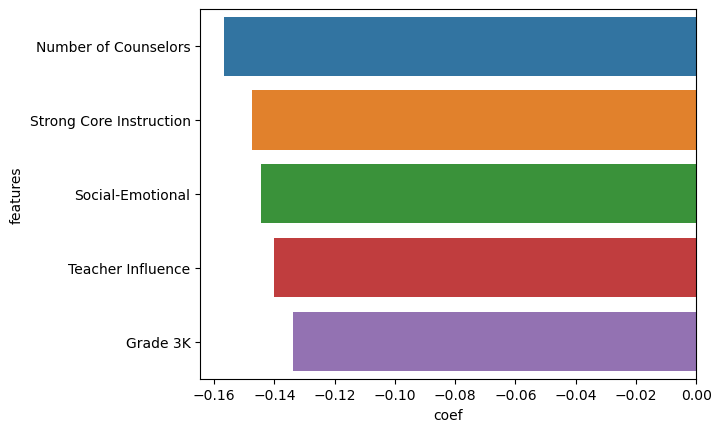

In [49]:
best_estimator = pipeline_lg_final[-1]

lr_features = pd.DataFrame(zip(X_train.columns, np.transpose(best_estimator.coef_)),
                           columns=['features', 'coef'])



top_5 = lr_features.sort_values('coef').head()
top_5["mean"] = top_5["features"].apply(lambda x: X_train[x].mean())
top_5["std"] = top_5["features"].apply(lambda x: X_train[x].std())
top_5["unnormalized coef"] = (top_5['coef']*top_5['std']) + top_5['mean']
top_5["unlogged"] = top_5["unnormalized coef"].apply(lambda x: np.exp(x))


top_5["coef"] = top_5["coef"].astype(float)

fig, ax = plt.subplots()
sns.barplot(data = top_5, x = "coef", y = "features");

top_5

# Recommendations

Based on my final model, I believe that the Department of Education should flag schools for high rates of absenteeism and provide additional funding to those schools for the following resources:

1. Additional guidance counselors and social works at the school

2. Additional staff that can lead small group instruction and independent projects for students who have fallen behind in reading and math during the pandemic

3. Further funds for field trips and community partnerships


# Next Steps

In order to improve my model I would want to scrape and find  data on the following:

1. Public transportation offered by each school.
2. Student employment
3. School Start Times
4. The number of tests given by a school
5. Suspension data
